In [10]:
# Load from pkl files
import pandas as pd
import pickle


with open('./Input/8-mers/mic_dframe.pkl', 'rb') as file:
    mic_dframe = pickle.load(file)
with open('./Input/8-mers/suscep_classes.pkl', 'rb') as file:
    suscep_classes = pd.read_pickle(file)


In [11]:
# Function that creates a dataframe with the number of genomes per class

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

def genomes_per_class(df, antibiotics):
    amounts = pd.DataFrame(data={})
    for antibiotic in antibiotics:
        single_amr = df[['Genome ID',antibiotic]].loc[pd.notnull(df[antibiotic])].drop_duplicates()
        if single_amr.shape[0] == 0:
            mics = [4]
            amount = [0]
        else:
            # Unique mic values
            mics = df[antibiotic].loc[pd.notnull(df[antibiotic])].sort_values().unique()
            amount = [len(single_amr.loc[single_amr[antibiotic]==mic]) for mic in mics]
        # Fiz uma alteracao para funcionar no pandas mais recente.
        amounts = pd.concat([amounts, pd.DataFrame(amount, index=mics).T], sort=True, ignore_index=True)
        #---------------------------------------------------------------
    return amounts

def susceptibility_heatmap(data, annot, antibiotics, title):
    sns.set_theme(font_scale=.8, style='white')
    myColors = ((0.0, 0.8, 0.0, 1.0), (0.0, 0.8, 0.8, 1.0), (0.8, 0.0, 0.0, 1.0))
    cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
    # Abbreviate the antibiotic names to 5 letters
    antibiotic_abbre = {i:antibiotics[i][:5].upper() for i in range(len(antibiotics))}
    # Number of genomes by Antibiotic and MIC.
    data = data.rename(index=antibiotic_abbre)
    # Set the width and height of the figure
    plt.figure(figsize=(10,6))
    # Add title
    plt.title(title, fontsize=12)
    # Heatmap showing the amount of genomes with the same MIC for each MIC, by antibiotic
    hp = sns.heatmap(data=data, annot=annot, cmap=cmap, fmt='.4g')
    # Manually specify colorbar labelling after it's been generated
    colorbar = hp.collections[0].colorbar
    colorbar.set_ticks([0.333, 1, 1.667])
    colorbar.set_ticklabels(['Susceptible', 'Intermediate', 'Resistant'])
    colorbar.ax.tick_params(labelsize=12)
    # Add label for horizontal axes
    plt.xlabel('MIC (micrograms per milliliter)', fontsize=12)
    plt.ylabel('Antibiotic', fontsize=12)

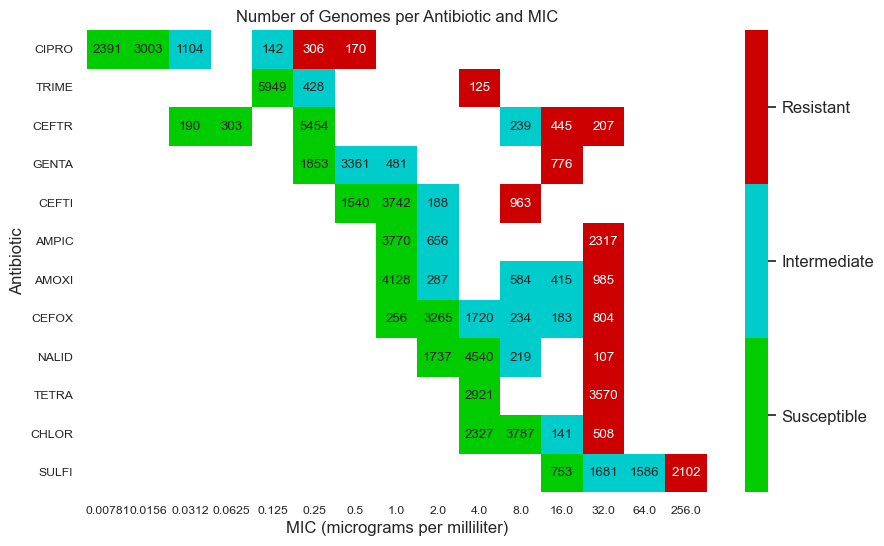

In [12]:
# Antibiotics
antibiotics = mic_dframe.columns[-12:]

# Comupute the distribution of MIC measurements
mic_distribution = genomes_per_class(mic_dframe, antibiotics)

# Combine the MIC distribution and the susceptibility map
title = 'Number of Genomes per Antibiotic and MIC'
susceptibility_heatmap(data=suscep_classes, annot=mic_distribution, antibiotics=antibiotics, title=title)


In [13]:
# Load the k-mer basis of k-mer counts

kmers = np.load('./input/8-mers/kmers_basis.npy')


In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def best_N_features(target_df, antibiotic, N):
    path = './input/8-mers/counts/'
    genome_ids = target_df['Genome ID'].loc[pd.notnull(target_df[antibiotic])].values
    X = np.array([np.load(path + genome_id + '.npy') for genome_id in genome_ids])
    y = target_df[antibiotic].loc[pd.notnull(target_df[antibiotic])].values
    n_best = SelectKBest(chi2, k=N)
    X_new = n_best.fit_transform(X, y*10**5)
    kmers = np.load('./input/8-mers/kmers_basis.npy')
    selected_kmers = [column[0]  for column in zip(kmers, n_best.get_support()) if column[1]]
    #scores = k_best.fit(X,y).scores_
    best_feature_df = pd.DataFrame(X_new, columns = selected_kmers)
    return best_feature_df

kmer_dframe = best_N_features(target_df=mic_dframe, antibiotic='ampicillin', N=200)

In [15]:
# Define the features input (X) and the target output (y) variables

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Select the antibiotic
antibiotic = 'ampicillin'

# Features
X = kmer_dframe.values

# Standardize the input data
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)

# Target
# list of MIC values
y = mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].values

# reshape the list of mics
y_reshape = np.reshape(y,(-1,1))

# define encoder function
encoder = OneHotEncoder(sparse_output=False)

# transform the target categorical data to onehot code
y_onehot = encoder.fit_transform(y_reshape)

# Split into the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.1, random_state=0)

In [19]:
# Define the classification model
import tensorflow as tf


# Model building function
def make_model(optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy'],):
    
    model = tf.keras.Sequential()
    initializer = tf.keras.initializers.HeNormal()
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer, use_bias=False, input_shape=[X.shape[1]]))
    model.add(tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax'))
    

    # Add the cross-entropy loss and accuracy metric for threshold probability
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    return model

# Define the model
model = make_model()

# Include an early stopping callback for convenience
early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor (loss or val_loss)
    monitor='val_loss',
    # how many epochs to wait before stopping (minimum epochs)
    patience=100,
    # minimium amount of change to count as an improvement
    min_delta=0.001,
    restore_best_weights=True,
)

/Applications/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
